<center>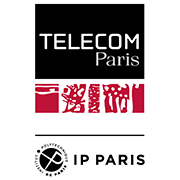</center>

<h1><center><strong><font color="green">IGR204 Visualisation<br/>Projet Baby name</font></strong></center></h1>

<h3><center><font color="blue"><strong>Groupe U</strong></font></center></h3>

<center>
<h3> Project student</h3>
<a>Nicolas Allègre</a> <email>nicolas.allegre@telecom-paris.fr</email><br>
<a>Romain Donné</a> <email>romain.donne@telecom-paris.fr</email><br>
<a>Aude De Fornel</a> <email>aude.defornel@telecom-paris.fr</email><br>
<a>François-Xavier Morel</a> <email>francois-xavier.morel@telecom-paris.fr</email><br>
<a>Camille Ishac</a> <email>camille.ishac@telecom-paris.fr</email><br>

<br/>
Année 2024-2025
</center>

------------------------

### Table of Contents

* [Chapter 0 Préparation](#0---préparation)
* [Chapter 4 - AMR](#4---amr)

<!-- <a class="anchor" id="0---code-python-initial"></a> -->

# <font color="green">**0 - Préparation**</font>

## 0.1) Partie code Python initial (import)

In [1]:
# python -m pip install matplotlib numpy tabulate altair geopandas pandas ipywidgets tkinter seaborn

###############################################################################
# IMPORTS :
# /* Modules standards */
import importlib
import os
import sys
import time
from pprint import pprint
from zipfile import ZipFile

# /* Modules externes */
import altair as alt
import ipywidgets as widgets
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import tkinter as tk
from tabulate import tabulate
from IPython.display import clear_output, display

# /* Modules internes */

###############################################################################
# CONSTANTES :
DATA_FOLDER = "../data"
DATA_ZIP = "Names hints.zip"
DATA_FILENAME = "dpt2020.csv"
GEO_FILENAME = "departements-version-simplifiee.geojson"

WIDTH = 600
HEIGHT = 600

root = tk.Tk()
screensize = root.winfo_screenwidth(), root.winfo_screenheight()
print(f"{screensize=}")
WIDTH = screensize[1] - 100

_ = alt.data_transformers.enable('json') # Let Altair/Vega-Lite work with large data sets


screensize=(1280, 720)


In [2]:
# Chargement du ZIP
zip_filenames = {}
filepath = os.path.join(DATA_FOLDER, DATA_ZIP)
zip_file = ZipFile(filepath)
for filename in [x.filename for x in zip_file.infolist()]:
    if DATA_FILENAME in filename:
        zip_filenames["data_path"] = filename
    elif GEO_FILENAME in filename:
        zip_filenames["geo_path"] = filename

# Chargement des données :
names = pd.read_csv(zip_file.open(zip_filenames["data_path"]), sep=";")

# Chargement de la cartographie :
depts = gpd.read_file(zip_file.open(zip_filenames["geo_path"]))

# Suppression des entrées sans prénom :
names.drop(names[names.preusuel == '_PRENOMS_RARES'].index, inplace=True)

# Suppression des entrées sans date :
names.drop(names[names.dpt == 'XX'].index, inplace=True)

# Conversion des types :
names.dpt = names.dpt.map(int)
names.annais = names.annais.map(int)
print(names.dtypes)


sexe         int64
preusuel    object
annais       int64
dpt          int64
nombre       int64
dtype: object


# <font color="green">**1 - Visualisation 1 : évolution des prénoms d’enfant, au cours du temps**</font>

La première visualisation concerne l'évolution temporelle des nommages d'enfants dans la France de 1900 à 2020.

Notamment, elle devrait permettre à répondre :
- Combien les noms d'enfant évoluent au cours du temps ?
- Y-a-t-il des noms qui sont perpertuellement populaire et non populaire ?
- Des tendances temporelles sont-elles présentes dans les noms d'enfant ?


Notre but est d'approcher notre proposition de visualisation avancé P1.12.

### 1.1) Étape 1 : élaboration des graphiques individuels nécessaires

#### **P1.2_GLOBAUX distribution de la popularité au travers les âges**

Graphique représentant une distribution sur la quantité de prénom issu d’une comptabilisation du nombre d’année qu’un prénom a été choisi au cours d’une année.

Il servira pour notre réflexion interne

In [ ]:
# Code pour P1.2 et tout autres graphiques d'aide à la réflexion

# Comptabiliser le nombre d'années où chaque prénom a été choisi
nb_annees_par_prenom = names.groupby('preusuel')['annais'].nunique().reset_index()
nb_annees_par_prenom.rename(columns={'annais': 'nb_annees'}, inplace=True)

# Créer la distribution (histogramme)
chart = alt.Chart(nb_annees_par_prenom).mark_bar().encode(
    alt.X('nb_annees:Q', bin=alt.Bin(maxbins=30), title="Nombre d'années où le prénom a été choisi"),
    alt.Y('count():Q', title="Nombre de prénoms")
).properties(
    title="durabilité des prénoms"
)

# TODO : chart_log : affichage logarithmique => chart | chart_log

chart

alt.Chart(...)

Réflexions :
- la popularité ne serait-elle pas les prénoms présent à droite du graphique, ayant été le plus présent.
- Est-ce que le nombre d'enfant est-il bien une mesure de popularité ?

#### **P1.1_GLOBAUX évolution moyenne au cours du temps**

Graphique représentant max,moyenne,médiane (voir sigma) avec le temps.

Ce graphique sera utilisé en début de notre visualisation avec une broche, permettant de réduire la fenêtre de temps.


In [4]:
# Code pour P1.1

# Calcul des statistiques par année
stats = names.groupby('annais')['nombre'].agg(
    max='max'
).reset_index()

# Transformation pour Altair (long format)
stats_long = stats.melt(id_vars='annais', var_name='statistique', value_name='valeur')

# Liste des années pour l'axe X
liste_annees = list(np.arange(1900, 2020, 10))

# Graphique
chart = alt.Chart(stats_long).mark_line(point=True).encode(
    x=alt.X('annais:O', axis=alt.Axis(values=liste_annees, title="Année", labelAngle=0)),
    y=alt.Y('valeur:Q', title="Valeur"),
    color=alt.Color('statistique:N', title="Statistique"),
    tooltip=['annais', 'statistique', 'valeur']
).properties(
    title="Max par année",
    width=WIDTH
)

chart

alt.Chart(...)

In [5]:
# Calcul des statistiques par année
stats = names.groupby('annais')['nombre'].agg(
    moyenne='mean',
    mediane='median',
    sigma='std'
).reset_index()

# Transformation pour Altair (long format)
stats_long = stats.melt(id_vars='annais', var_name='statistique', value_name='valeur')

# Liste des années pour l'axe X
liste_annees = list(np.arange(1900, 2020, 10))

# Graphique
chart = alt.Chart(stats_long).mark_line(point=True).encode(
    x=alt.X('annais:O', axis=alt.Axis(values=liste_annees, title="Année", labelAngle=0)),
    y=alt.Y('valeur:Q', title="Valeur"),
    color=alt.Color('statistique:N', title="Statistique"),
    tooltip=['annais', 'statistique', 'valeur']
).properties(
    title="Moyenne, Médiane et Sigma par année",
    width=WIDTH
)

chart

alt.Chart(...)

#### **P1.7_évolution au cours du temps de K prénoms**

Graphique similaire au précédent mais pour K prénom.

Ce graphique devra comprendre : une tooltip avec année,nb,nom,(?moy/med/sig?), la légende des noms


In [8]:
# Code pour 1.7

###############################################################################
## PARAMÈTRES DE VISU :
POPULAIRE = True  # Populaire ou non populaire
K = 5  # Nombre de prénoms à afficher
USERNAME = ""  # Vide ou donné
LIST_USERNAME = []  # liste spécique ou automatique TOP
SEXE = "all"  # "ALL", "M", "F"

###############################################################################
# 1- Construction de la liste des prénoms à afficher
top_K = (
    names.groupby('preusuel')['nombre']
    .sum()
    .sort_values(ascending=not POPULAIRE)
    .head(K)
    .index
)

# 2- Filtrage des données à afficher
filtered = names[names['preusuel'].isin(top_K)]
agg = (
    filtered.groupby(['annais', 'preusuel'])['nombre']
    .sum()
    .reset_index()
)

###############################################################################
# 3- Construction des graphiques

# Lignes principales
lines = alt.Chart(agg).mark_line().encode(
    x=alt.X('annais:O',
        title='Année',
        axis=alt.Axis(values=[i for i in range(1900, 2021, 10)], labelAngle=0)
    ),
    y=alt.Y('nombre:Q', title='Nombre de naissances'),
    color=alt.Color('preusuel:N', title='Prénom'),
    tooltip=['preusuel', 'annais', 'nombre']
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

# Zones de conflit (fixe rouge transparent)
conflicts_df = pd.DataFrame({
    'start': [1914, 1939],
    'end': [1918, 1945]
})

zones = alt.Chart(conflicts_df).mark_rect(
    opacity=0.2,
    color='red'
).encode(
    x='start:O',
    x2='end:O'
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

# Légende "Période de conflit" ajoutée manuellement
legend_dummy = alt.Chart(pd.DataFrame({
    'label': ['Période de conflit']
})).mark_rect(opacity=0.2).encode(
    color=alt.Color('label:N',
    scale=alt.Scale(domain=['Période de conflit'],
    range=['red']),
    legend=alt.Legend(title=''))
)

# Combinaison finale sans .height sur le chart global
chart = alt.layer(zones, lines).resolve_scale(color='independent')
final_chart = chart & legend_dummy

final_chart.properties(
    title=f'Évolution des {K} prénoms les plus populaires (avec périodes de conflit)'
)


alt.VConcatChart(...)

Dans ce qu'on observe, il y a deux source de variabilité : 
 - une liée à l'attribution d'un prénom
 - une autre liée au nombre de naissance ayant eu lieu pour l'année en question

 Ainsi, pour saisir les tendances sur les prénoms, il est nécessaire de se débarasser de la variabilité liée au nombre de naissances. 

In [20]:
nb_of_birth = {}
time_span = range(names.annais.min(),  names.annais.max()+1)
for year in time_span:
    nb_of_birth[year] = names[ names.annais == year]["nombre"].sum()
    
mean_nb_birth = np.mean(list(nb_of_birth.values()))
names["rectified_nb"] = mean_nb_birth * names["nombre"] / names["annais"].map(nb_of_birth)


On ajoute également la pédiode des 30 glorieuses, en bleu et on compare l'évolution de 1900 à nos jours des prénoms : 
- les plus populaires en France sur l'ensemble de la pédiode
- les plus populaires entre 2010-2020

In [12]:
###############################################################################
## PARAMÈTRES DE VISU :
POPULAIRE = True  # Populaire ou non populaire
K = 5  # Nombre de prénoms à afficher
USERNAME = ""  # Vide ou donné
LIST_USERNAME = []  # liste spécique ou automatique TOP
SEXE = "all"  # "ALL", "M", "F"

###############################################################################
# --------- 1. Prénoms les plus populaires sur toute la période ---------
# 1- Construction de la liste des prénoms à afficher
top_K_all = (
    names.groupby('preusuel')['nombre']
    .sum()
    .sort_values(ascending=not POPULAIRE)
    .head(K)
    .index
)
# 2- Filtrage des données à afficher
filtered_all = names[names['preusuel'].isin(top_K_all)]
agg_all = (
    filtered_all.groupby(['annais', 'preusuel'])['nombre']
    .sum()
    .reset_index()
)

# --------- 2. Prénoms les plus populaires depuis 2010 ---------
recent_names = names[names['annais'] >= 2010]
top_K_recent = (
    recent_names.groupby('preusuel')['rectified_nb']
    .sum()
    .sort_values(ascending=not POPULAIRE)
    .head(K)
    .index
)
filtered_recent = names[names['preusuel'].isin(top_K_recent)]
agg_recent = (
    filtered_recent.groupby(['annais', 'preusuel'])['rectified_nb']
    .sum()
    .reset_index()
)

# --------- Contexte historique ---------
conflicts_df = pd.DataFrame({
    'start': [1914, 1939],
    'end': [1918, 1945]
})
glorieuses_df = pd.DataFrame({
    'start': [1945],
    'end': [1975]
})

war = alt.Chart(conflicts_df).mark_rect(
    opacity=0.2,
    color='red'
).encode(
    x='start:O',
    x2='end:O'
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

glor = alt.Chart(glorieuses_df).mark_rect(
    opacity=0.2,
    color='blue'
).encode(
    x='start:O',
    x2='end:O'
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

###############################################################################
# 3- Construction des graphiques

# --------- Chart 1 : Top 10 global ---------
lines_all = alt.Chart(agg_all).mark_line().encode(
    x=alt.X('annais:O',
        title='Année',
        axis=alt.Axis(values=[i for i in range(1900, 2021, 10)], labelAngle=0)
    ),
    y=alt.Y('nombre:Q', title='Nombre de naissances'),
    color=alt.Color('preusuel:N', title='Prénom'),
    tooltip=['preusuel', 'annais', 'nombre']
).properties(
    width=WIDTH,
    height=HEIGHT/2
)
chart_all = alt.layer(war, glor, lines_all).resolve_scale(color='independent').properties(
    title='Top 10 prénoms de la période 1900-2020)'
)

# --------- Chart 2 : Top 10 depuis 2010 ---------
lines_recent = alt.Chart(agg_recent).mark_line().encode(
    x=alt.X('annais:O',
        title='Année',
        axis=alt.Axis(values=[i for i in range(1900, 2021, 10)], labelAngle=0)
    ),
    y=alt.Y('rectified_nb:Q', title="Nombre ajusté d'attributions"),
    color=alt.Color('preusuel:N', title='Prénom'),
    tooltip=['preusuel', 'annais', 'rectified_nb']
).properties(
    width=WIDTH,
    height=HEIGHT/2
)
chart_recent = alt.layer(war, glor, lines_recent).resolve_scale(color='independent').properties(
    title='Top 10 prénoms des années 2010-2020'
)

# --------- Affichage côte à côte ---------
final_chart = alt.vconcat(chart_all, chart_recent).resolve_scale(color='independent')
final_chart


alt.VConcatChart(...)

On constate un problème d'échelle, car les prénoms les plus populaires dans les années récentes sont 10 fois moins attribués que les prénoms top-10 sur l'ensemble de la période. On va faire une super-rectification pour prendre en compte l'augmentation du champ des possibles en termes de prénoms.

In [13]:
# Nombre de prénoms différents par année
nb_unique_names_per_year = names.groupby('annais')['preusuel'].nunique()

# Moyenne globale sur toute la période
mean_nb_names = nb_unique_names_per_year.mean()

# Création de la colonne
names['super_rectified_number'] = (
    names['rectified_nb'] / names['annais'].map(nb_unique_names_per_year)
) * mean_nb_names


In [14]:
###############################################################################
## PARAMÈTRES DE VISU :
POPULAIRE = True  # Populaire ou non populaire
K = 5  # Nombre de prénoms à afficher
USERNAME = ""  # Vide ou donné
LIST_USERNAME = []  # liste spécique ou automatique TOP
SEXE = "all"  # "ALL", "M", "F"

###############################################################################
# --------- 1. Prénoms les plus populaires sur toute la période ---------
# 1- Construction de la liste des prénoms à afficher
top_K_all = (
    names.groupby('preusuel')['super_rectified_number']
    .sum()
    .sort_values(ascending=not POPULAIRE)
    .head(K)
    .index
)
# 2- Filtrage des données à afficher
filtered_all = names[names['preusuel'].isin(top_K_all)]
agg_all = (
    filtered_all.groupby(['annais', 'preusuel'])['super_rectified_number']
    .sum()
    .reset_index()
)

# --------- 2. Prénoms les plus populaires depuis 2010 ---------
recent_names = names[names['annais'] >= 2010]
top_K_recent = (
    recent_names.groupby('preusuel')['super_rectified_number']
    .sum()
    .sort_values(ascending=not POPULAIRE)
    .head(K)
    .index
)
filtered_recent = names[names['preusuel'].isin(top_K_recent)]
agg_recent = (
    filtered_recent.groupby(['annais', 'preusuel'])['super_rectified_number']
    .sum()
    .reset_index()
)

# --------- Contexte historique ---------
conflicts_df = pd.DataFrame({
    'start': [1914, 1939],
    'end': [1918, 1945]
})
glorieuses_df = pd.DataFrame({
    'start': [1945],
    'end': [1975]
})

war = alt.Chart(conflicts_df).mark_rect(
    opacity=0.2,
    color='red'
).encode(
    x='start:O',
    x2='end:O'
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

glor = alt.Chart(glorieuses_df).mark_rect(
    opacity=0.2,
    color='blue'
).encode(
    x='start:O',
    x2='end:O'
).properties(
    width=WIDTH,
    height=HEIGHT/2
)

###############################################################################
# 3- Construction des graphiques
# --------- Chart 1 : Top 10 global ---------
lines_all = alt.Chart(agg_all).mark_line().encode(
    x=alt.X('annais:O',
        title='Année',
        axis=alt.Axis(values=[i for i in range(1900, 2021, 10)], labelAngle=0)
    ),
    y=alt.Y('super_rectified_number:Q', title="Nombre ajusté d'attributions"),
    color=alt.Color('preusuel:N', title='Prénom'),
    tooltip=['preusuel', 'annais', 'super_rectified_number']
).properties(
    width=WIDTH,
    height=HEIGHT/2
)
chart_all = alt.layer(war, glor, lines_all).resolve_scale(color='independent').properties(
    title='Top 10 prénoms (toute période)'
)

# --------- Chart 2 : Top 10 depuis 2010 ---------
lines_recent = alt.Chart(agg_recent).mark_line().encode(
    x=alt.X('annais:O',
        title='Année',
        axis=alt.Axis(values=[i for i in range(1900, 2021, 10)], labelAngle=0)
    ),
    y=alt.Y('super_rectified_number:Q', title="Nombre ajusté d'attributions"),
    color=alt.Color('preusuel:N', title='Prénom'),
    tooltip=['preusuel', 'annais', 'super_rectified_number']
).properties(
    width=WIDTH,
    height=HEIGHT/2
)
chart_recent = alt.layer(war, glor, lines_recent).resolve_scale(color='independent').properties(
    title='Top 10 prénoms des années 2010-2020)'
)

# --------- Affichage côte à côte ---------
final_chart = alt.vconcat(chart_all, chart_recent).resolve_scale(color='independent')
final_chart

alt.VConcatChart(...)

Paradoxalement, le phénomène est encore plus marqué : sur l'ensemble de la période. Il faut faire l'hypothèse que la polarisation entre les prénoms très rares et les prénoms très populaires est beaucoup plus marquée que sur la fin de la période. 

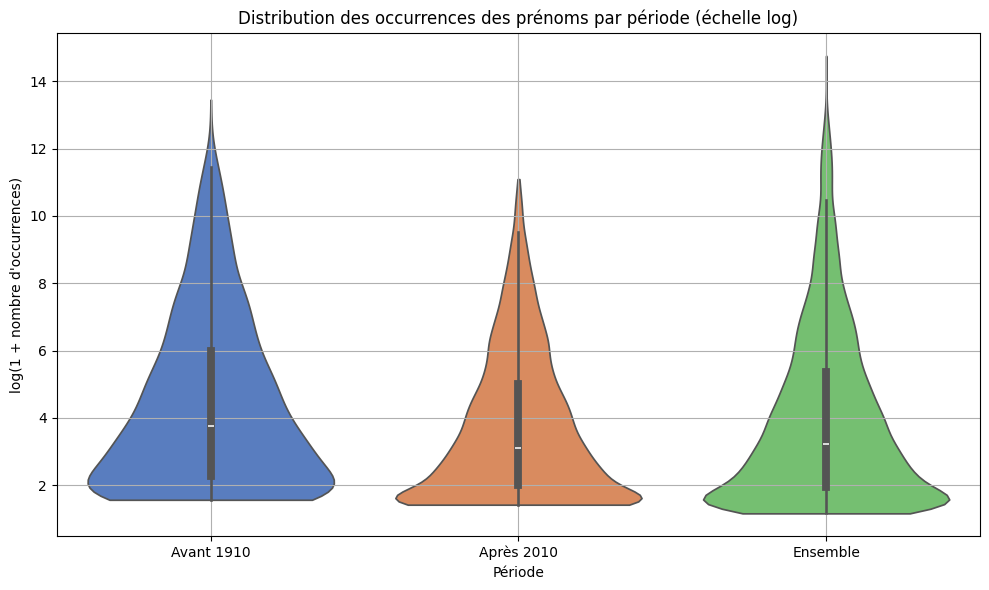

In [21]:
# Découpage en 3 périodes
df_avant = names[names['annais'] < 1910].groupby('preusuel', as_index=False)['rectified_nb'].sum()
df_avant['période'] = 'Avant 1910'

df_apres = names[names['annais'] >= 2010].groupby('preusuel', as_index=False)['rectified_nb'].sum()
df_apres['période'] = 'Après 2010'

df_ensemble = names.groupby('preusuel', as_index=False)['rectified_nb'].sum()
df_ensemble['période'] = 'Ensemble'

# Fusion des trois
df_violin = pd.concat([df_avant, df_apres, df_ensemble], ignore_index=True)

# Optionnel : transformation log pour échelle plus lisible
df_violin['log_nombre'] = np.log1p(df_violin['rectified_nb'])

# Plot avec Seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_violin, x='période', y='log_nombre', palette='muted', cut=0, hue='période', legend=False)
plt.title("Distribution des occurrences des prénoms par période (échelle log)")
plt.ylabel("log(1 + nombre d'occurrences)")
plt.xlabel("Période")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Désactivation JSON Altair
# alt.data_transformers.enable('default', max_rows=None)

# Liste des prénoms uniques
prenoms_uniques = sorted(names['preusuel'].unique())

# Récupération des bornes d'années dans les données
min_annee = names['annais'].min()
max_annee = names['annais'].max()

# Widgets
search_box = widgets.Text(
    value='',
    placeholder='Tape un prénom ou une partie...',
    description='Recherche :',
    layout=widgets.Layout(width='50%')
)

select_box = widgets.SelectMultiple(
    options=prenoms_uniques,
    value=['ANNA'],  # Valeurs initiales
    description='Prénoms :',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

annee_slider = widgets.IntRangeSlider(
    value=[1950, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    continuous_update=False,
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Fonction d’affichage du graphique avec filtre sur les années
def afficher_graphique(prenoms, annee_range=None):
    output.clear_output()
    with output:
        if not prenoms:
            print("Sélectionne au moins un prénom.")
            return

        df_k = names[names.preusuel.isin(prenoms)]
        
        if annee_range:
            df_k = df_k[(df_k['annais'] >= annee_range[0]) & (df_k['annais'] <= annee_range[1])]

        df_k_grouped = df_k.groupby(['preusuel', 'annais'])['nombre'].sum().reset_index()

        chart = alt.Chart(df_k_grouped).mark_line(point=True).encode(
            x=alt.X('annais:O', title="Année"),
            y=alt.Y('nombre:Q', title="Nombre de naissances"),
            color=alt.Color('preusuel:N', title="Prénom"),
            tooltip=['preusuel', 'annais', 'nombre']
        ).properties(
            title=f"Évolution des prénoms ({annee_range[0]}–{annee_range[1]})",
            width=WIDTH
        )
        display(chart)

# SelectMultiple widget pour la sélection de prénoms
def on_text_change(change):
    filtre = change['new'].lower()
    filtres_matches = [p for p in prenoms_uniques if filtre in p.lower()]
    selected = list(select_box.value)
    nouvelles_options = sorted(set(filtres_matches + selected))
    select_box.options = nouvelles_options
    select_box.value = tuple(selected)


def on_interaction_change(change=None):
    afficher_graphique(select_box.value, annee_range=annee_slider.value)

# Événements
search_box.observe(on_text_change, names='value')
select_box.observe(lambda change: on_interaction_change(), names='value')
annee_slider.observe(lambda change: on_interaction_change(), names='value')

# Affichage
display(widgets.VBox([search_box, select_box, annee_slider]))
afficher_graphique(select_box.value, annee_slider.value)
display(output)


Output()

In [32]:
prenoms_filtrés = []  # Liste de prénoms visible selon le sexe sélectionné
updating_sexe = False  # Pour éviter la boucle infinie

# Widgets
search_box = widgets.Text(
    value='',
    placeholder='Tape un prénom...',
    description='Recherche :',
    layout=widgets.Layout(width='50%')
)

select_box = widgets.SelectMultiple(
    options=[],
    value=[],
    description='Prénoms :',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

min_annee = names['annais'].min()
max_annee = names['annais'].max()

annee_slider = widgets.IntRangeSlider(
    value=[1950, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    continuous_update=False,
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

# Boutons de filtre par sexe
bouton_homme = widgets.ToggleButton(description="Homme", value=False)
bouton_femme = widgets.ToggleButton(description="Femme", value=False)
bouton_tous = widgets.ToggleButton(description="Tous", value=True)

bouton_sexe_box = widgets.HBox([bouton_homme, bouton_femme, bouton_tous])
output = widgets.Output()


# Fonctions
def get_sexe_selection():
    if bouton_homme.value and not bouton_femme.value:
        return 1
    elif bouton_femme.value and not bouton_homme.value:
        return 2
    else:
        return None

def update_prenoms_visibles():
    global prenoms_filtrés
    sexe_actuel = get_sexe_selection()

    if sexe_actuel is None:
        df = names
    else:
        df = names[names['sexe'] == sexe_actuel]

    prenoms_filtrés = sorted(df['preusuel'].unique())

    # Met à jour les options dans le SelectMultiple
    filtre = search_box.value.lower()
    filtres_matches = [p for p in prenoms_filtrés if filtre in p.lower()]
    selected = [p for p in select_box.value if p in prenoms_filtrés]
    select_box.options = sorted(set(filtres_matches + selected))
    select_box.value = tuple(selected)

def afficher_graphique(prenoms, annee_range=None, sexe_filtre=None):
    output.clear_output()
    with output:
        if not prenoms:
            print("Sélectionne au moins un prénom.")
            return

        df_k = names[names.preusuel.isin(prenoms)]

        if annee_range:
            df_k = df_k[(df_k['annais'] >= annee_range[0]) & (df_k['annais'] <= annee_range[1])]
        if sexe_filtre in [1, 2]:
            df_k = df_k[df_k['sexe'] == sexe_filtre]

        df_k_grouped = df_k.groupby(['preusuel', 'annais'])['nombre'].sum().reset_index()

        chart = alt.Chart(df_k_grouped).mark_line(point=True).encode(
            x=alt.X('annais:O', title="Année"),
            y=alt.Y('nombre:Q', title="Nombre de naissances"),
            color=alt.Color('preusuel:N', title="Prénom"),
            tooltip=['preusuel', 'annais', 'nombre']
        ).properties(
            title=f"Évolution ({annee_range[0]}–{annee_range[1]}) - Sexe : {'Tous' if sexe_filtre is None else ('Femme' if sexe_filtre==2 else 'Homme')}",
            width=WIDTH
        )
        display(chart)

def on_text_change(change):
    filtre = change['new'].lower()
    filtres_matches = [p for p in prenoms_filtrés if filtre in p.lower()]
    selected = list(select_box.value)
    nouvelles_options = sorted(set(filtres_matches + selected))
    select_box.options = nouvelles_options
    select_box.value = tuple([p for p in selected if p in nouvelles_options])

def update_sexe_buttons(source):
    global updating_sexe
    if updating_sexe:
        return
    updating_sexe = True

    if source == "homme":
        bouton_homme.value = True
        bouton_femme.value = False
        bouton_tous.value = False
    elif source == "femme":
        bouton_homme.value = False
        bouton_femme.value = True
        bouton_tous.value = False
    else:  
        bouton_homme.value = False
        bouton_femme.value = False
        bouton_tous.value = True

    updating_sexe = False
    update_prenoms_visibles()
    on_interaction_change()

def on_interaction_change(change=None):
    sexe_filtre = get_sexe_selection()
    afficher_graphique(select_box.value, annee_range=annee_slider.value, sexe_filtre=sexe_filtre)

# Lier les événements
search_box.observe(on_text_change, names='value')
select_box.observe(lambda change: on_interaction_change(), names='value')
annee_slider.observe(lambda change: on_interaction_change(), names='value')

bouton_homme.observe(lambda change: update_sexe_buttons("homme"), names='value')
bouton_femme.observe(lambda change: update_sexe_buttons("femme"), names='value')
bouton_tous.observe(lambda change: update_sexe_buttons("tous"), names='value')


# Initialisation et affichage
update_prenoms_visibles()
select_box.value = ['ANNA']  # Valeur initiale si disponible

display(widgets.VBox([
    search_box,
    select_box,
    annee_slider,
    bouton_sexe_box
]))

afficher_graphique(select_box.value, annee_slider.value, get_sexe_selection())
display(output)

Output()

#### **P1.4_Ranking des prénoms populaires et non populaires (K premiers & K derniers)**

Graphique représentant un classement des K premiers noms.

Nous allons nous focaliser d'abords à représenter la popularité.

Ce graphique doit comprendre : le nombre total, la position et le nom


In [ ]:
# Code pour 1.4



#### **Graphiques dynamiques**

Si altair peut faire un graphique sous forme de vidéo, alors tester sur le P1.7.
- => P1.9_Top global des prénoms
- ou => P1.10_TOP locaux des prénoms


In [11]:
# Code pour 1.9

### 1.2) Étape 2 : fusionner pour construire la visualisation

#### **P1.12_proposition de visualisation temporelle des prénoms d’enfant**

Dans un premier temps, avec des paramètres construire la visualisation.

Rappel disposition :
- en premier, le graphique général P1.1 sur toutes la largeur avec la possibilité de réduire le temps.
- le graphique des ranking de K prénom + nom donnée (P1.4)
- le graphique évolution des prénoms sélectionné (P1.7)

Progression :
- Dans un premier temps, grâce à des variables Python.
- Dans un second temps, si Altair le permet rajouter de la dynamique (clic de sélection, ...)


In [21]:
# Code pour visualisaition 1

###############################################################################
## PARAMÈTRES DE VISU :
POPULAIRE = True  # Populaire ou non populaire
K = 5  # Nombre de prénoms à afficher
USERNAME = ""  # Vide ou donné
LIST_USERNAME = []  # liste spécique ou automatique TOP
SEXE = "all"  # "ALL", "M", "F"


###############################################################################
# 1.1 - Construire la liste des K users 
list_k_user_auto = []  # à partir dataset ordonnée croissante

# 1.2 - Filtrage pour avoir les noms à afficher
list_names = []
# Récupérer d'abords les prénoms donnés par l'utilisateur et compléter par les tops.
for i in range(K):
    if len(LIST_USERNAME) > i:
        list_names.append(LIST_USERNAME[i])
    elif len(list_k_user_auto) > i:
        list_names.append(list_k_user_auto.pop(0))
# Rajouter le nom spécial de l'utilisateur
if USERNAME != "":
    list_names.append(USERNAME)

###############################################################################


# <font color="green">**2 - Visualisation 2 : évolution des prénoms d’enfant, géographiquement**</font>

Le seconde visualisation concerne l'évolution géographique des nommages d'enfants dans la France métropolitaine de 1900 à 2020.

Notamment, elle devrait permettre à répondre :
- Y-a-t-il un effect régional ?
- Des noms sont plus populaires dans certaines régions ?
- Les noms populaires globalement le sont-ils dans toutes les régions française ?

Notre but est d'approcher notre proposition de visualisation avancé P2.6.

### 1.1) Étape 1 : élaboration des graphiques individuels nécessaires

#### **P2.1_GLOBAUX répartition moyenne de K prénoms en couleur**

Graphique représentant une sorte de heatmap des K prénoms sur une carte de la France.

Le graphique doit contenir : une tooltip pour chaque département (dpt,nom,nb)

In [22]:
# Code P2.1

# Sélectionner les K prénoms les plus fréquents
K = 50
top_prenoms = names.groupby('preusuel')['nombre'].sum().nlargest(K).index.tolist()
df_top = names[names['preusuel'].isin(top_prenoms)]

# Agréger le nombre par département et prénom
df_agg = df_top.groupby(['dpt', 'preusuel'], as_index=False)['nombre'].sum()

# Harmoniser les codes département
df_agg['dpt'] = df_agg['dpt'].astype(str).str.zfill(2)
depts['code'] = depts['code'].astype(str).str.zfill(2)

# Repérer les lignes pour la Corse (code '20')
corse_rows = df_agg[df_agg['dpt'] == '20']

# Dupliquer pour '2A' et '2B'
corse_2A = corse_rows.copy()
corse_2A['dpt'] = '2A'
corse_2B = corse_rows.copy()
corse_2B['dpt'] = '2B'

# Ajouter à df_agg
df_agg = pd.concat([df_agg, corse_2A, corse_2B], ignore_index=True)

# Pour chaque département, trouver le prénom dominant parmi les K
idx = df_agg.groupby('dpt')['nombre'].idxmax()
dominant = df_agg.loc[idx].reset_index(drop=True)
dominant = dominant.rename(columns={'preusuel': 'prenom_dominant', 'nombre': 'nb_dominant'})

# Fusionner avec la géographie
depts_dominant = depts.merge(dominant, left_on='code', right_on='dpt', how='left')

# Affichage Altair
chart = alt.Chart(depts_dominant).mark_geoshape().encode(
    color=alt.Color('prenom_dominant:N', title='Prénom dominant', scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('code:N', title='Département'),
        alt.Tooltip('nom:N', title='Nom'),
        alt.Tooltip('prenom_dominant:N', title='Prénom dominant'),
        alt.Tooltip('nb_dominant:Q', title='Nombre')
    ]
).project(
    type='mercator'
).properties(
    width=WIDTH,
    height=HEIGHT,
    title=f"Prénom dominant parmi les {K} plus fréquents par département"
)

chart

alt.Chart(...)

In [24]:
# Afficher les K prénoms les plus fréquents avec leur nombre total
top_prenoms_df = names.groupby('preusuel', as_index=False)['nombre'].sum()
top_prenoms_df = top_prenoms_df.sort_values(['nombre', 'preusuel'], ascending=[False, True])
top_prenoms_df.head(K)


,preusuel,nombre
9147,MARIE,2256072
6292,JEAN,1913130
11699,PIERRE,891794
10109,MICHEL,818025
921,ANDRÉ,709633
6434,JEANNE,556903
11676,PHILIPPE,535355
8241,LOUIS,523576
12099,RENÉ,514560
427,ALAIN,504106


In [25]:
# Sélectionner les K prénoms les plus fréquents
K = 5
top_prenoms = names.groupby('preusuel')['nombre'].sum().nlargest(K).index.tolist()
df_top = names[names['preusuel'].isin(top_prenoms)]

# Agréger le nombre par département et prénom
df_agg = df_top.groupby(['dpt', 'preusuel'], as_index=False)['nombre'].sum()

# Préparer les données pour l'animation
df_agg = names.groupby(['annais', 'dpt', 'preusuel'], as_index=False)['nombre'].sum()

# Harmoniser les codes département
df_agg['dpt'] = df_agg['dpt'].astype(str).str.zfill(2)
depts['code'] = depts['code'].astype(str).str.zfill(2)

# Repérer les lignes pour la Corse (code '20')
corse_rows = df_agg[df_agg['dpt'] == '20']

# Dupliquer pour '2A' et '2B'
corse_2A = corse_rows.copy()
corse_2A['dpt'] = '2A'
corse_2B = corse_rows.copy()
corse_2B['dpt'] = '2B'

# Ajouter à df_agg
df_agg = pd.concat([df_agg, corse_2A, corse_2B], ignore_index=True)

# Pour chaque département et année, trouver le prénom dominant
idx = df_agg.groupby(['annais', 'dpt'])['nombre'].idxmax()
dominant = df_agg.loc[idx].reset_index(drop=True)
dominant = dominant.rename(columns={'preusuel': 'prenom_dominant', 'nombre': 'nb_dominant'})

# Fusionner avec la géographie
depts_dominant = depts.merge(dominant, left_on='code', right_on='dpt', how='left')

# Créer l'animation Altair
chart = alt.Chart(depts_dominant).mark_geoshape().encode(
    color=alt.Color('prenom_dominant:N', title='Prénom dominant', scale=alt.Scale(scheme='category10')),
    tooltip=[
        alt.Tooltip('code:N', title='Département'),
        alt.Tooltip('nom:N', title='Nom'),
        alt.Tooltip('prenom_dominant:N', title='Prénom dominant'),
        alt.Tooltip('nb_dominant:Q', title='Nombre')
    ]
).properties(
    width=WIDTH,
    height=HEIGHT,
    title="Prénom dominant par département et année"
).add_params(
    alt.param(
        name="year",
        value=1900,
        bind=alt.binding_range(min=1900, max=2020, step=1, name="Année")
    )
).transform_filter(
    alt.datum.annais == alt.param("year")
)

chart

alt.Chart(...)

#### **P2.3_répartition d’un prénom en couleur (heatmap)**

Graphique représentant la heatmap d'un prénom sur la carte de la France.

In [27]:
# Code P2.3

def plot_heatmap(prenom):
    df_sel = df_agg[df_agg['preusuel'] == prenom]
    chart = alt.Chart(depts).mark_geoshape().encode(
        color=alt.Color('nombre:Q', scale=alt.Scale(scheme='reds'), title='Nombre'),
        tooltip=[
            alt.Tooltip('code:N', title='Département'),
            alt.Tooltip('nom:N', title='Nom'),
            alt.Tooltip('nombre:Q', title='Nb')
        ]
    ).transform_lookup(
        lookup='code',
        from_=alt.LookupData(df_sel, 'dpt', ['nombre'])
    ).project(
        type='mercator'
    ).properties(
        width=WIDTH,
        height=HEIGHT,
        title=f"Heatmap du prénom {prenom} sur la carte de France"
    )
    return chart


# Sélectionner les K prénoms les plus fréquents
K = 5  # Nombre de prénoms à afficher
top_prenoms = names.groupby('preusuel')['nombre'].sum().nlargest(K).index.tolist()
df_top = names[names['preusuel'].isin(top_prenoms)]

# Liste de tous les départements
all_dpts = depts['code'].unique()

# Produit cartésien pour chaque prénom x chaque département
full_index = pd.MultiIndex.from_product([all_dpts, top_prenoms], names=['dpt', 'preusuel'])
df_agg = df_top.groupby(['dpt', 'preusuel'], as_index=False)['nombre'].sum().set_index(['dpt', 'preusuel'])
df_agg = df_agg.reindex(full_index, fill_value=0).reset_index()

# Sélectionner un prénom
input_dropdown = alt.binding_select(options=top_prenoms, name='Prénom ')
selection = alt.selection_point(fields=['preusuel'], bind=input_dropdown, value=top_prenoms[0])

widgets.interact(plot_heatmap, prenom=top_prenoms)


interactive(children=(Dropdown(description='prenom', options=('MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ'), v…

<function __main__.plot_heatmap(prenom)>

In [ ]:
# Sélectionner les K prénoms les plus fréquents
K = 5
top_prenoms = names.groupby('preusuel')['nombre'].sum().nlargest(K).index.tolist()

# Filtrer les données pour ne conserver que les K prénoms
df_top = names[names['preusuel'].isin(top_prenoms)]

# Agréger les données par année, département et prénom
df_agg = df_top.groupby(['annais', 'dpt', 'preusuel'], as_index=False)['nombre'].sum()

# Harmoniser les codes département
df_agg['dpt'] = df_agg['dpt'].astype(str).str.zfill(2)
depts['code'] = depts['code'].astype(str).str.zfill(2)

# Repérer les lignes pour la Corse (code '20')
corse_rows = df_agg[df_agg['dpt'] == '20']

# Dupliquer pour '2A' et '2B'
corse_2A = corse_rows.copy()
corse_2A['dpt'] = '2A'
corse_2B = corse_rows.copy()
corse_2B['dpt'] = '2B'

# Ajouter à df_agg
df_agg = pd.concat([df_agg, corse_2A, corse_2B], ignore_index=True)

# Pour chaque département et année, trouver le prénom dominant
idx = df_agg.groupby(['annais', 'dpt'])['nombre'].idxmax()
dominant = df_agg.loc[idx].reset_index(drop=True)
dominant = dominant.rename(columns={'preusuel': 'prenom_dominant', 'nombre': 'nb_dominant'})

# Palette de couleurs fixe pour les prénoms
color_scale = alt.Scale(
    domain=top_prenoms,  # Les prénoms du top K
    range=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Couleurs fixes
)

# Fonction pour afficher la carte pour une année donnée
def plot_year(year):
    df_sel = dominant[dominant['annais'] == year]
    depts_dominant_year = depts.merge(df_sel, left_on='code', right_on='dpt', how='left')
    
    chart = alt.Chart(depts_dominant_year).mark_geoshape().encode(
        color=alt.Color('prenom_dominant:N', title='Prénom dominant', scale=color_scale),
        tooltip=[
            alt.Tooltip('code:N', title='Département'),
            alt.Tooltip('nom:N', title='Nom'),
            alt.Tooltip('prenom_dominant:N', title='Prénom dominant'),
            alt.Tooltip('nb_dominant:Q', title='Nombre')
        ]
    ).project(
        type='mercator'
    ).properties(
        width=WIDTH,
        height=HEIGHT,
        title=f"Prénom dominant parmi les {K} plus fréquents en {year}"
    )
    return chart

# Animation année par année
start_year = 1900
end_year = 2020

for year in range(start_year, end_year + 1):
    clear_output(wait=True)  # Efface l'affichage précédent
    display(plot_year(year))  # Affiche la carte pour l'année en cours
    time.sleep(1)  # Pause de 1 seconde

### 1.2) Étape 2 : fusionner pour construire la visualisation

#### **P2.6_proposition de visualisation temporelle des prénoms d’enfant**


Rappel disposition :
- en premier, une échelle de temps modifiable ou la France heatmap avec le temps modifiable.
- la heatmap des K top ou du prénom



In [15]:
# Code pour visualisation 2

###############################################################################
## PARAMÈTRES DE VISU :
POPULAIRE = True  # Populaire ou non populaire
K = 5  # Nombre de prénoms à afficher
USERNAME = ""  # Vide ou donné
LIST_USERNAME = []  # liste spécique ou automatique TOP
LIST_DPT = []  # liste spécique ou automatique département
SEXE = "all"  # "ALL", "M", "F"


###############################################################################
# 1.1 - Construire la liste des K users 
list_k_user_auto = []  # à partir dataset ordonnée croissante

# 1.2 - Filtrage pour avoir les noms à afficher
list_names = []
# Récupérer d'abords les prénoms donnés par l'utilisateur et compléter par les tops.
for i in range(K):
    if len(LIST_USERNAME) > i:
        list_names.append(LIST_USERNAME[i])
    elif len(list_k_user_auto) > i:
        list_names.append(list_k_user_auto.pop(0))
# Rajouter le nom spécial de l'utilisateur
if USERNAME != "":
    list_names.append(USERNAME)

###############################################################################


# <font color="green">**3 - Visualisation 3 :  évolution des prénoms d’enfant, en fonction du sexe**</font>

La troisième visualisation concerne l'évolution genrée des nommages d'enfants dans la France de 1900 à 2020.

Notamment, elle devrait permettre à répondre à :
- Le sexe influe-t-il sur les évolutions des noms ?
- La popularité des noms évolue-t-elle similairement pour les deux sexes ?


In [5]:
d_sets = {}
l_sexes = set(names.sexe)
l_annees = set(names.annais)
l_prenoms = [set(names.preusuel)]
l_prenoms.extend([set(names[names["sexe"]==i].preusuel) for i in l_sexes])
d_sets["sexes"] = l_sexes
d_sets["annees"] = l_annees
# [0] : all / [1] : homme / [2] : femme
d_sets["prenoms"] = l_prenoms

nb_uniq = len(set(names.preusuel))
nb_uniq_s = [len(l_prenoms[i]) for i in range(len(l_prenoms))]
l_prenoms_unisexe = set(names.preusuel) - (l_prenoms[1]-l_prenoms[2]) - (l_prenoms[2]-l_prenoms[1])
d_sets["prenoms_unisexe"] = l_prenoms_unisexe

print(f"Nombre de prénom unique par sexe : {nb_uniq_s[1:]} sur {nb_uniq} en globals.")
print(f"Soit {len(l_prenoms_unisexe)} prénom non genré")
list(l_prenoms_unisexe)[:10]


Nombre de prénom unique par sexe : [7289, 8849] sur 15270 en globals.
Soit 868 prénom non genré


['NARCISSE',
 'ISLEM',
 'HIPPOLYTE',
 'VALERE',
 'MAÏLEY',
 'EMMANUEL',
 'SHANNON',
 'JOSEPH',
 'MERYL',
 'EPIPHANE']

In [7]:
# Récupération des bornes d'années dans les données
min_annee = names['annais'].min()
max_annee = names['annais'].max()

# Widgets
search_box = widgets.Text(
    value='',
    placeholder='Chercher un prénom unisexe...',
    description='Recherche :',
    layout=widgets.Layout(width='50%')
)
select_box = widgets.SelectMultiple(
    options=l_prenoms_unisexe,
    value=['ISLEM'],  # Valeurs initiales
    description='Prénoms :',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

annee_slider = widgets.IntRangeSlider(
    value=[1901, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    continuous_update=False,
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Fonction d’affichage du graphique avec filtre sur les années
def afficher_graphique(prenoms, annee_range=None):
    output.clear_output()
    with output:
        if not prenoms:
            print("Sélectionne au moins un prénom.")
            return

        df_k = names[names.preusuel.isin(prenoms)]
        
        if annee_range:
            df_k = df_k[(df_k['annais'] >= annee_range[0]) & (df_k['annais'] <= annee_range[1])]

        # df_k_grouped = df_k.groupby(['preusuel', 'annais'])['nombre'].sum().reset_index()
        # Grouper par prénom, sexe et année
        df_k_grouped = df_k.groupby(['preusuel', 'sexe', 'annais'])['nombre'].sum().reset_index()
        # Convertir sexe en label textuel (plus lisible)
        df_k_grouped['sexe_label'] = df_k_grouped['sexe'].map({1: 'Masculin', 2: 'Féminin'})

        chart = alt.Chart(df_k_grouped).mark_line(point=True).encode(
            x=alt.X('annais:O', title="Année"),
            y=alt.Y('nombre:Q', title="Nombre de naissances"),
            # color=alt.Color('preusuel:N', title="Prénom"),
            color=alt.Color('sexe_label:N', title="Sexe"),
            strokeDash=alt.StrokeDash('preusuel:N', title="Prénom"),
            tooltip=['preusuel', 'sexe_label', 'annais', 'nombre']
        ).properties(
            title=f"Évolution des prénoms ({annee_range[0]}–{annee_range[1]})",
            width=WIDTH
        )
        display(chart)

# SelectMultiple widget pour la sélection de prénoms
def on_text_change(change):
    filtre = change['new'].lower()
    filtres_matches = [p for p in prenoms_uniques if filtre in p.lower()]
    selected = list(select_box.value)
    nouvelles_options = sorted(set(filtres_matches + selected))
    select_box.options = nouvelles_options
    select_box.value = tuple(selected)


def on_interaction_change(change=None):
    afficher_graphique(select_box.value, annee_range=annee_slider.value)

# Événements
search_box.observe(on_text_change, names='value')
select_box.observe(lambda change: on_interaction_change(), names='value')
annee_slider.observe(lambda change: on_interaction_change(), names='value')

# Affichage
display(widgets.VBox([search_box, select_box, annee_slider]))
afficher_graphique(select_box.value, annee_slider.value)
display(output)

# TOP :
# 'NARCISSE',
#  'ISLEM',
#  'HIPPOLYTE',
#  'VALERE',
#  'MAÏLEY',
#  'EMMANUEL',
#  'SHANNON',
#  'JOSEPH',
#  'MERYL',
#  'EPIPHANE'


Output()

Nous constations qu'il y a données incorrectes et incohérente dans le sexe aussi ou des évènements étrange.

Améliorations possibles :
- Filtrer les noms qui ne sont pas unisexe
  - très peu occurence multi-sexe, sexe prédominant
- Filtrer les noms n'étant que sur quelques années.
  - Indirectement effectuer en effectuer un TOP sur les noms unisexes filtré.
